In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear_marginalized.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

import getdist
from getdist import plots, MCSamples

%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])
PZ = [0]*nz
for i in range(nz):
    z = np.concatenate([np.linspace(-0.5, 0, 100), pz_fid[i].get_knots()[1:]])
    p = np.concatenate([np.zeros(100), pz_fid[i](pz_fid[i].get_knots()[1:])])
    PZ[i] = interpolate.InterpolatedUnivariateSpline(z, p, k = 3)
pz_fid = PZ

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
npar = 15

# Define the priors
lower = np.zeros(npar)
upper = np.zeros(npar)
lower[0:5] = np.array([0, 0.4, 0, 0.4, 0.7])
lower[5:] = np.ones(nz)*-0.1
upper[0:5] = np.array([1, 1.2, 0.1, 1.0, 1.3])
upper[5:] = np.ones(nz)*0.1
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
sigmas[5:] = np.ones(nz)*0.05
S = np.eye(npar)*sigmas**2
Sinv = np.linalg.inv(S)
prior_args = [prior_mean, S, lower, upper]

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.concatenate([abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.1, 0.1, 0.05]), np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])])
dCdt = np.zeros((npar, nz, nz, len(modes)))
# Derivatives wrt cosmological parameters
for i in range(npar-nz):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])
    
# Derivatives wrt photo-z bias parameters
for i in range(nz):
    
    pzprime = [interpolate.InterpolatedUnivariateSpline(np.linspace(0, pz_fid[0].get_knots()[-1], len(pz_fid[0].get_knots())), np.zeros(len(pz_fid[0].get_knots()))) for X in range(nz)]
    pzprime[i] = pz_fid[i].derivative()
    dCdt[npar-nz+i, :, :, :] = d_power_spectrum_db(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz)), pzprime])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Sinv)

# Compute projection matrices
Fpinv = np.linalg.inv(F[5:,5:])
P = np.zeros((5, 10))
for i in range(5):
    P[i,:] = np.dot(Fpinv, F[i,5:])

# Projection arguments
projection_args = [Finv, P, theta_fiducial, fisher_errors, prior_mean, Sinv, Cinv, dCdt, modes, nl]

# SimABC args
simulator_args = [sim_args, projection_args, prior_args]

# Now do the set up for the nuisance projected problem...
npar = 5
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(npar)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
Finv = Finv[0:npar, 0:npar]
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
def simulator(x, *args):

    return simulationABC(x, args[0])

In [4]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, simulator_args = simulator_args, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 74s 2ms/step - loss: 16.5559 - val_loss: 12.4482
Epoch 2/100
45000/45000 [==============================] - 123s 3ms/step - loss: 11.5698 - val_loss: 10.7573
Epoch 3/100
45000/45000 [==============================] - 78s 2ms/step - loss: 10.2003 - val_loss: 9.7304
Epoch 4/100
45000/45000 [==============================] - 72s 2ms/step - loss: 9.2531 - val_loss: 8.9491
Epoch 5/100
45000/45000 [==============================] - 75s 2ms/step - loss: 8.6310 - val_loss: 8.5419
Epoch 6/100
45000/45000 [==============================] - 78s 2ms/step - loss: 8.1312 - val_loss: 7.8866
Epoch 7/100
45000/45000 [==============================] - 73s 2ms/step - loss: 7.7362 - val_loss: 7.5716
Epoch 8/100
45000/45000 [==============================] - 74s 2ms/step - loss: 7.4355 - val_loss: 7.3181
Epoch 9/100
45000/45000 [===

45000/45000 [==============================] - 81s 2ms/step - loss: 3.9919 - val_loss: 3.9307
Epoch 77/100
45000/45000 [==============================] - 68s 2ms/step - loss: 4.0035 - val_loss: 3.9351
Epoch 78/100
45000/45000 [==============================] - 96s 2ms/step - loss: 4.0187 - val_loss: 4.1582
Epoch 79/100
45000/45000 [==============================] - 98s 2ms/step - loss: 3.9930 - val_loss: 4.1086
Epoch 80/100
45000/45000 [==============================] - 87s 2ms/step - loss: 3.9970 - val_loss: 4.0284
Epoch 81/100
45000/45000 [==============================] - 82s 2ms/step - loss: 3.9723 - val_loss: 3.9069
Epoch 82/100
45000/45000 [==============================] - 94s 2ms/step - loss: 4.0006 - val_loss: 3.8791
Epoch 83/100
45000/45000 [==============================] - 109s 2ms/step - loss: 4.0135 - val_loss: 4.0505
Epoch 84/100
45000/45000 [==============================] - 93s 2ms/step - loss: 3.9689 - val_loss: 3.9381
Epoch 85/100
45000/45000 [=======================

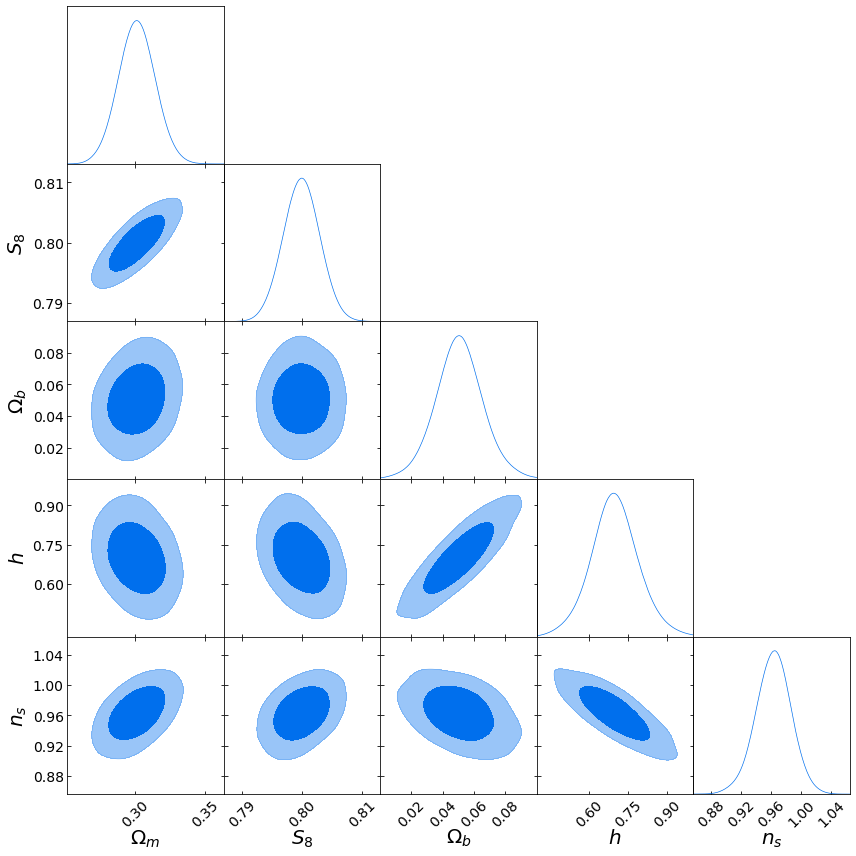

In [ ]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=100)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 2ms/step - loss: 12.0547 - val_loss: 10.0972
Epoch 2/100
450/450 [==============================] - 1s 2ms/step - loss: 8.7908 - val_loss: 7.7214
Epoch 3/100
450/450 [==============================] - 1s 2ms/step - loss: 7.8335 - val_loss: 7.3329
Epoch 4/100
450/450 [==============================] - 1s 2ms/step - loss: 6.8974 - val_loss: 6.8114
Epoch 5/100
450/450 [==============================] - 1s 2ms/step - loss: 6.2220 - val_loss: 5.8334
Epoch 6/100
450/450 [==============================] - 2s 4ms/step - loss: 5.8483 - val_loss: 5.6224
Epoch 7/100
450/450 [==============================] - 1s 2ms/step - loss: 5.7339 - val_loss: 5.9294
Epoch 8/100
450/450 [==============================] - 1s 2ms/step - loss: 6.0440 - val_loss: 5.4533
Epoch 9/100
450/450 [==============================] - 1s 2ms/step - loss: 5.6326 - val_loss: 5.1412
Epoch 10/1

450/450 [==============================] - 1s 2ms/step - loss: 4.4654 - val_loss: 4.4033
Epoch 81/100
450/450 [==============================] - 1s 2ms/step - loss: 4.4024 - val_loss: 4.4177
Epoch 82/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3633 - val_loss: 4.3819
Epoch 83/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3316 - val_loss: 4.3333
Epoch 84/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3638 - val_loss: 4.4161
Epoch 85/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3386 - val_loss: 4.3400
Epoch 86/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3869 - val_loss: 4.3632
Epoch 87/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3473 - val_loss: 4.3990
Epoch 88/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3828 - val_loss: 4.4114
Epoch 89/100
450/450 [==============================] - 1s 2ms/step - loss: 4.3894 - val_loss: 

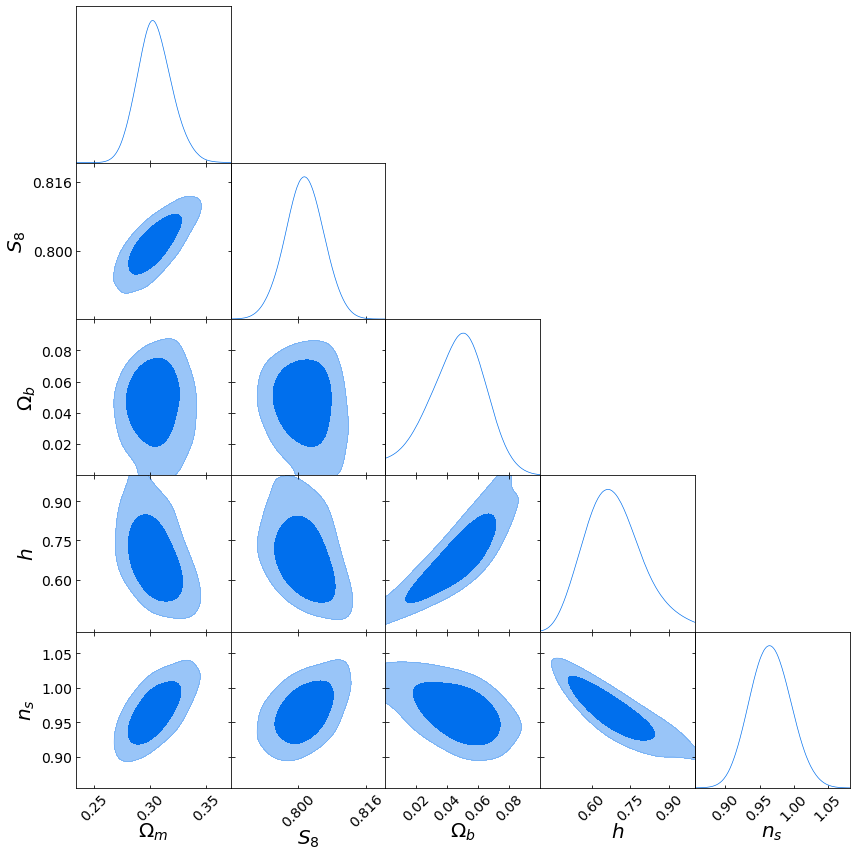

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 4s 5ms/step - loss: 4.2573 - val_loss: 4.1771
Epoch 2/100
900/900 [==============================] - 4s 4ms/step - loss: 4.2512 - val_loss: 4.4862
Epoch 3/100
900/900 [==============================] - 4s 4ms/step - loss: 4.2930 - val_loss: 4.1700
Epoch 4/100
900/900 [==============================] - 4s 4ms/step - loss: 4.2917 - val_loss: 4.1789
Epoch 5/100
900/900 [==============================] - 4s 5ms/step - loss: 4.2814 - val_loss: 4.4076
Epoch 6/100
900/900 [==============================] - 6s 6ms/step - loss: 4.2719 - val_loss: 4.2093
Epoch 7/100
900/900 [==============================] - 7s 8ms/step - loss: 4.2433 - val_loss: 4.1600
Epoch 8/100
900/900 [==============================] - 5s 5ms/step - loss: 4.2098 - val_loss: 4.2085
Epoch 9/100
900/900 [==============================] - 3s 4ms/step - 

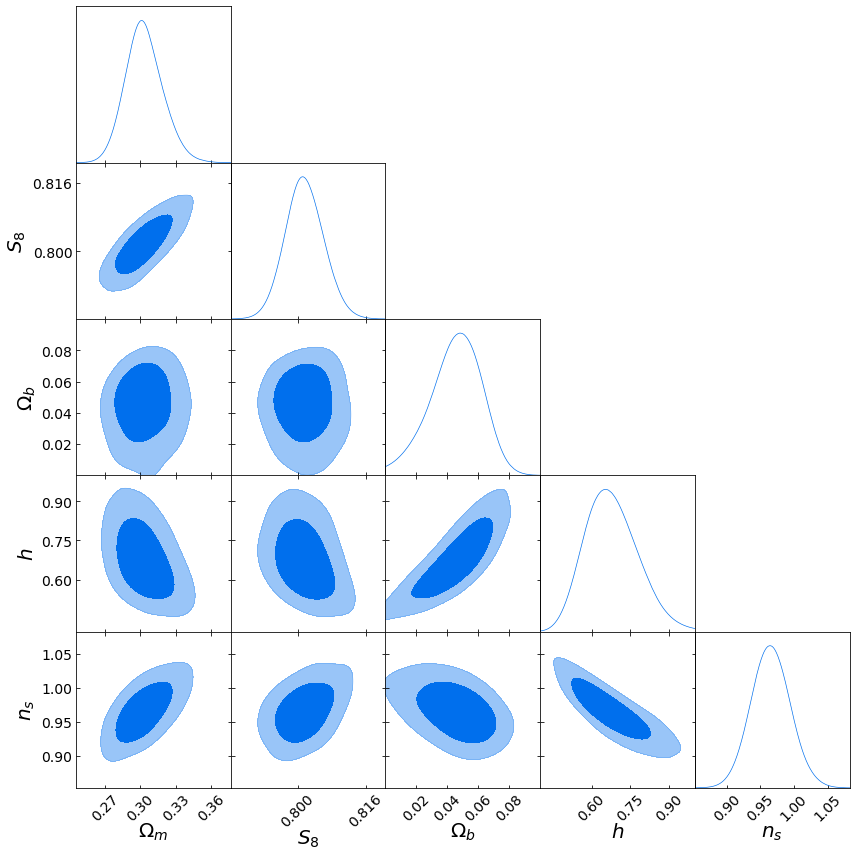

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.2692 - val_loss: 3.8027
Epoch 2/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.1669 - val_loss: 3.8035
Epoch 3/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.1536 - val_loss: 3.8236
Epoch 4/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.2178 - val_loss: 3.8272
Epoch 5/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.2044 - val_loss: 3.7953
Epoch 6/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.1752 - val_loss: 3.8784
Epoch 7/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.1929 - val_loss: 3.7305
Epoch 8/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.1383 - val_loss: 3.7594
Epoch 9/100
1350/1350 [=============================

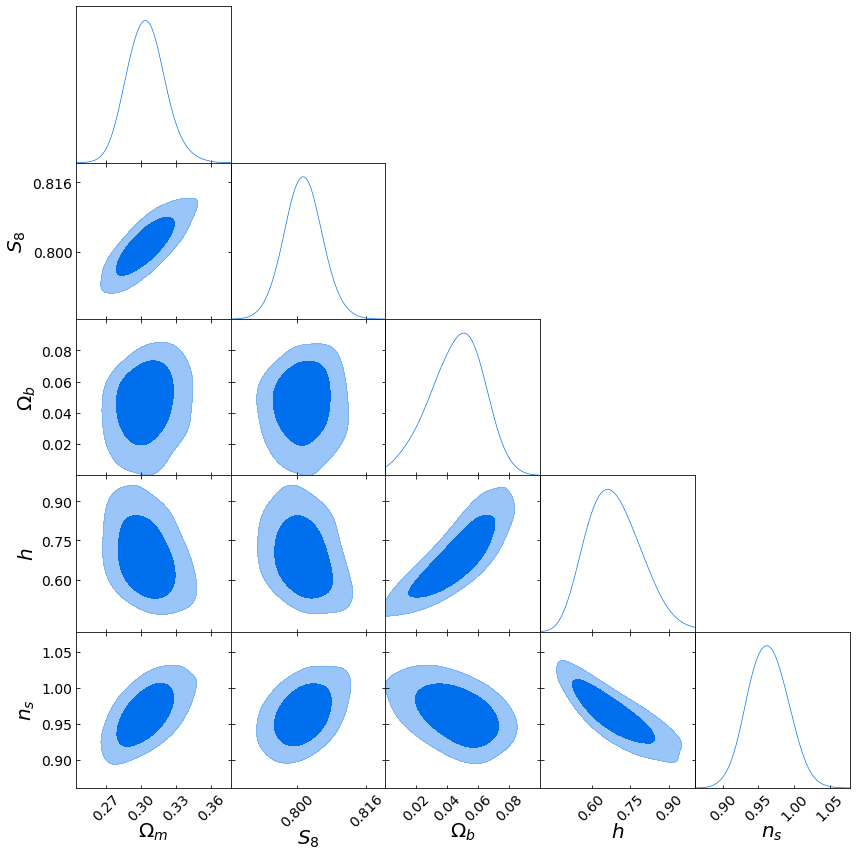

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 3s 1ms/step - loss: 4.0470 - val_loss: 3.8010
Epoch 2/100
1800/1800 [==============================] - 3s 2ms/step - loss: 4.0487 - val_loss: 3.8718
Epoch 3/100
1800/1800 [==============================] - 3s 2ms/step - loss: 4.0802 - val_loss: 3.9191
Epoch 4/100
1800/1800 [==============================] - 4s 2ms/step - loss: 4.0751 - val_loss: 3.8058
Epoch 5/100
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0654 - val_loss: 3.8121
Epoch 6/100
1800/1800 [==============================] - 5s 3ms/step - loss: 4.0347 - val_loss: 3.8258
Epoch 7/100
1800/1800 [==============================] - 3s 2ms/step - loss: 4.0159 - val_loss: 3.8327
Epoch 8/100
1800/1800 [==============================] - 3s 1ms/step - loss: 4.0317 - val_loss: 3.8018
Epoch 9/100
1800/1800 [=============================

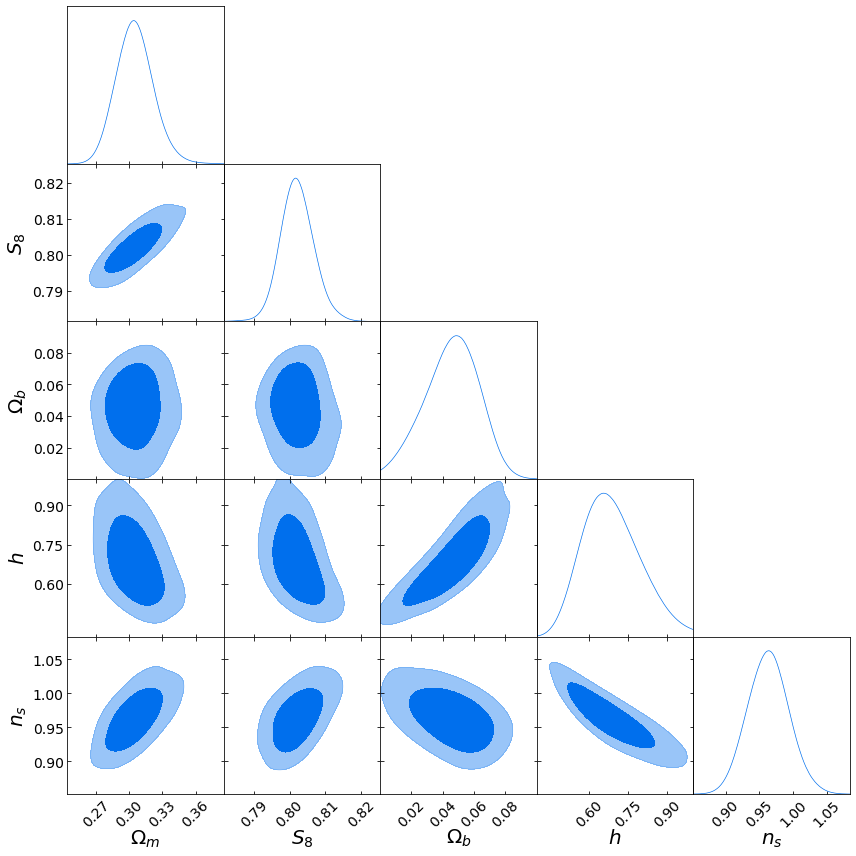

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.0278 - val_loss: 4.1776
Epoch 2/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9914 - val_loss: 4.2056
Epoch 3/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9907 - val_loss: 4.1872
Epoch 4/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9912 - val_loss: 4.1354
Epoch 5/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9915 - val_loss: 4.1521
Epoch 6/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9738 - val_loss: 4.1983
Epoch 7/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9943 - val_loss: 4.1800
Epoch 8/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9993 - val_loss: 4.1858
Epoch 9/100
2250/2250 [=============================

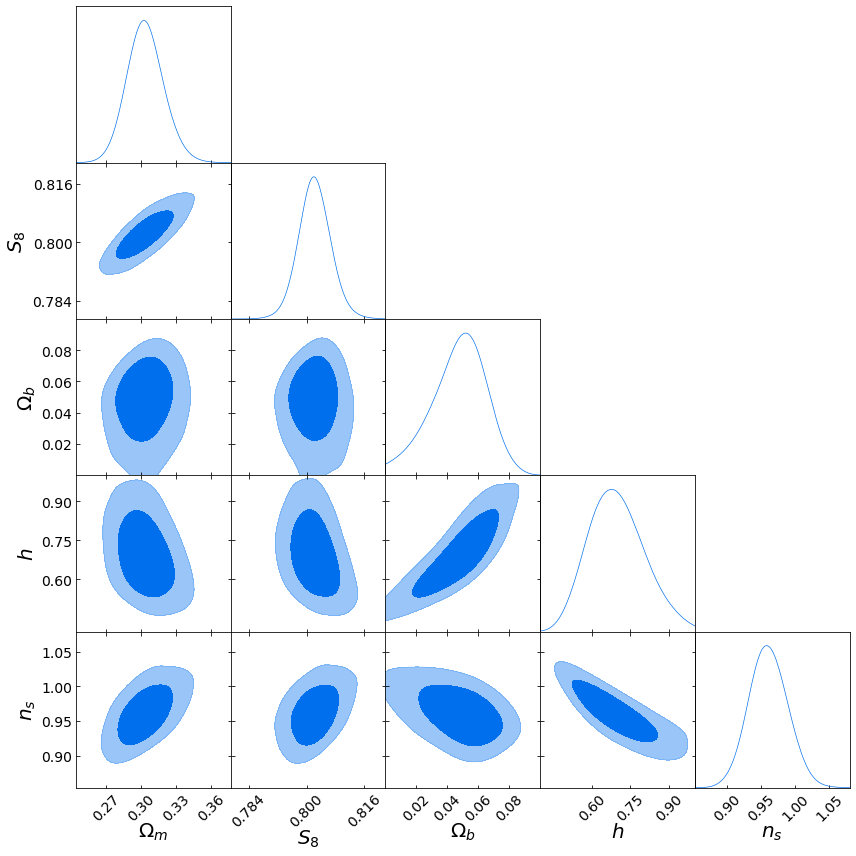

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0077 - val_loss: 4.1534
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0160 - val_loss: 4.0409
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0042 - val_loss: 4.0695
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.9911 - val_loss: 4.0453
Epoch 5/100
2700/2700 [==============================] - 4s 2ms/step - loss: 3.9849 - val_loss: 4.0517
Epoch 6/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.9971 - val_loss: 4.0162
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.9882 - val_loss: 4.0209
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.9846 - val_loss: 4.0176
Epoch 9/100
2700/2700 [=============================

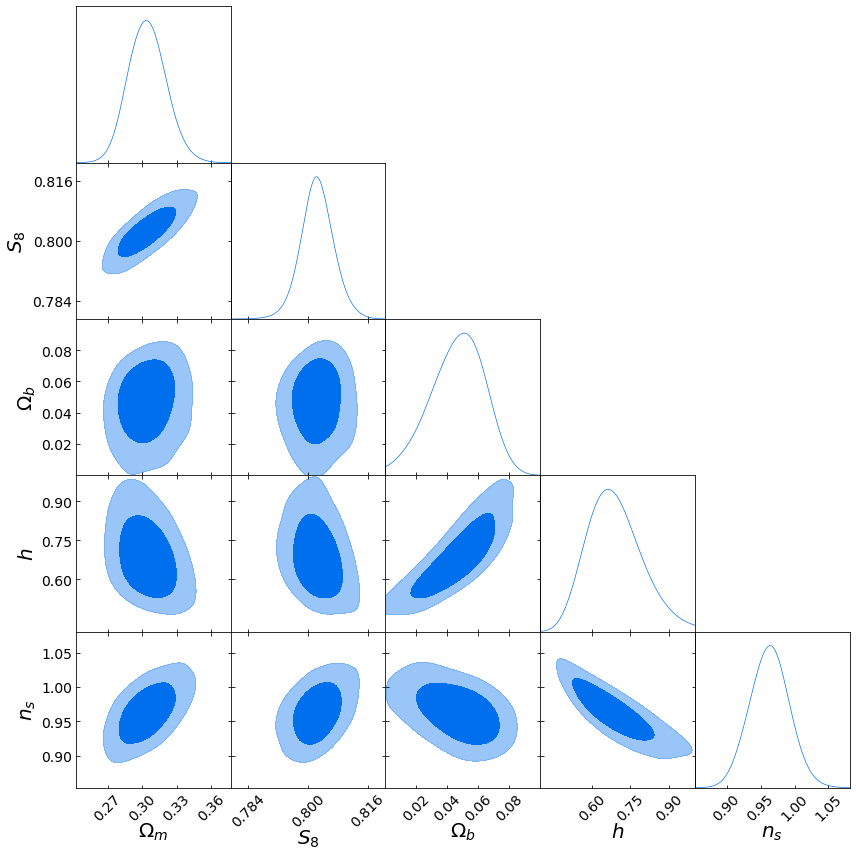

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.9678 - val_loss: 3.9455
Epoch 2/100
3150/3150 [==============================] - 7s 2ms/step - loss: 3.9786 - val_loss: 4.0646
Epoch 3/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9801 - val_loss: 3.9127
Epoch 4/100
3150/3150 [==============================] - 5s 2ms/step - loss: 3.9629 - val_loss: 4.0033
Epoch 5/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.9620 - val_loss: 3.9793
Epoch 6/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.9710 - val_loss: 3.9145
Epoch 7/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.9693 - val_loss: 4.0163
Epoch 8/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9606 - val_loss: 3.9166
Epoch 9/100
3150/3150 [=============================

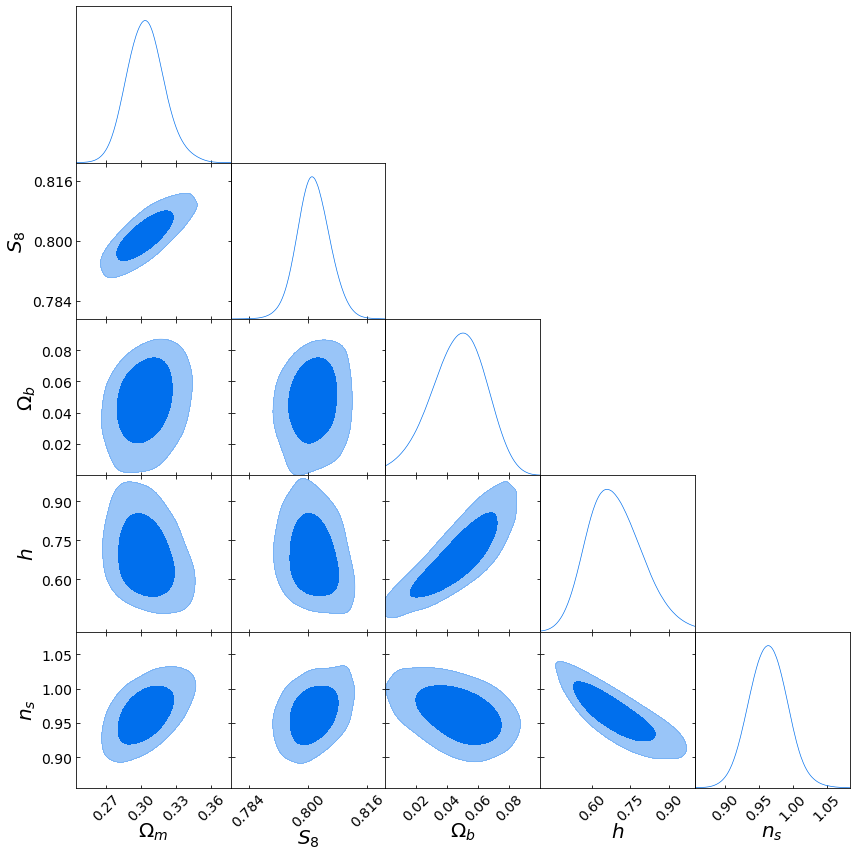

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9586 - val_loss: 3.8745
Epoch 2/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9557 - val_loss: 3.8949
Epoch 3/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9488 - val_loss: 3.8857
Epoch 4/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9358 - val_loss: 3.8690
Epoch 5/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9386 - val_loss: 3.8750
Epoch 6/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9319 - val_loss: 3.8735
Epoch 7/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9421 - val_loss: 3.8647
Epoch 8/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9328 - val_loss: 3.8761
Epoch 9/100
3600/3600 [=============================

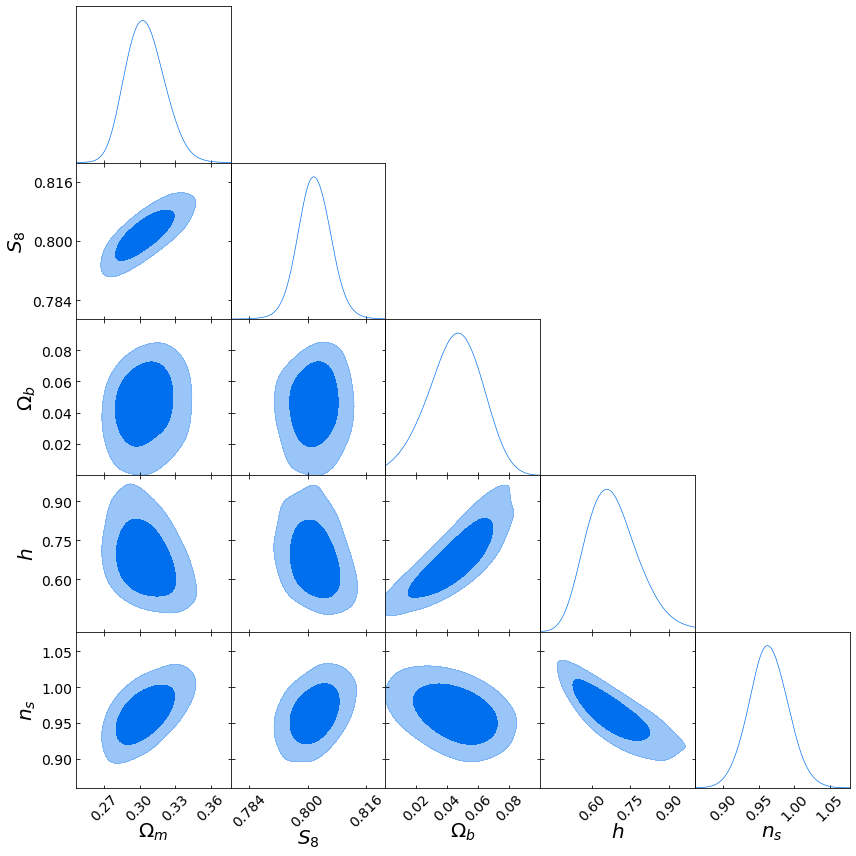

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 9s 2ms/step - loss: 3.9302 - val_loss: 4.0093
Epoch 2/100
4050/4050 [==============================] - 8s 2ms/step - loss: 3.9270 - val_loss: 3.9975
Epoch 3/100
4050/4050 [==============================] - 10s 2ms/step - loss: 3.9271 - val_loss: 3.9974
Epoch 4/100
4050/4050 [==============================] - 10s 2ms/step - loss: 3.9350 - val_loss: 4.0182
Epoch 5/100
4050/4050 [==============================] - 9s 2ms/step - loss: 3.9272 - val_loss: 4.0112
Epoch 6/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9356 - val_loss: 4.0307
Epoch 7/100
4050/4050 [==============================] - 6s 2ms/step - loss: 3.9285 - val_loss: 4.0104
Epoch 8/100
4050/4050 [==============================] - 6s 2ms/step - loss: 3.9286 - val_loss: 4.0878
Epoch 9/100
4050/4050 [===========================

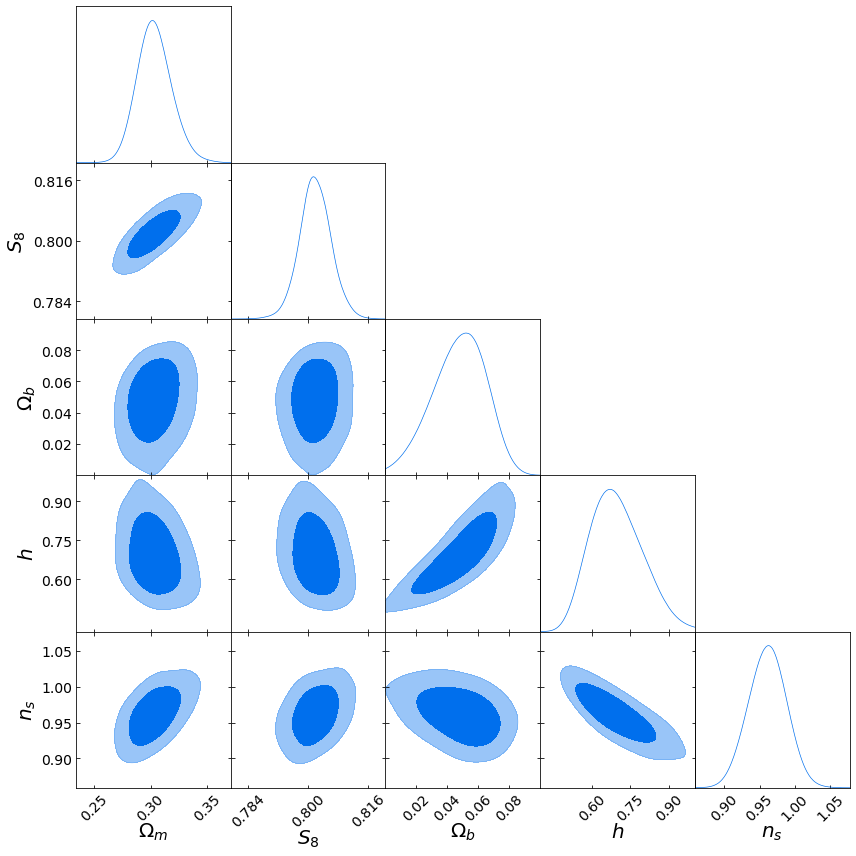

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9384 - val_loss: 3.9494
Epoch 2/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9254 - val_loss: 3.9438
Epoch 3/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9201 - val_loss: 3.9642
Epoch 4/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9437 - val_loss: 3.9753
Epoch 5/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9390 - val_loss: 3.9369
Epoch 6/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9235 - val_loss: 4.0996
Epoch 7/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9622 - val_loss: 3.9747
Epoch 8/100
4500/4500 [==============================] - 8s 2ms/step - loss: 3.9414 - val_loss: 3.9552
Epoch 9/100
4500/4500 [=============================

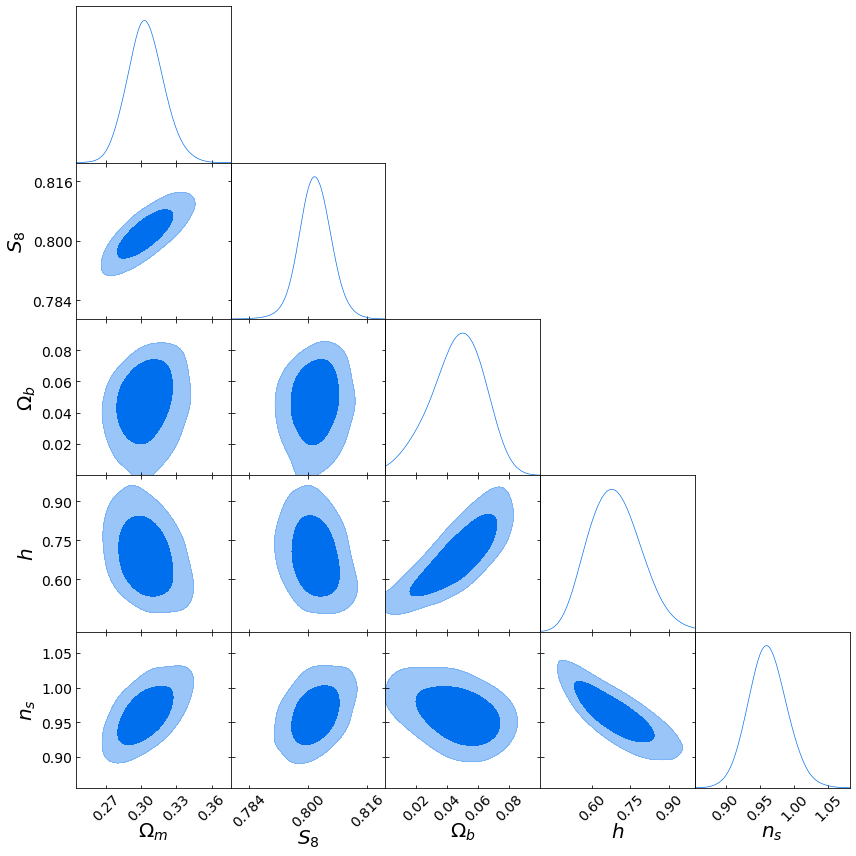

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 9s 2ms/step - loss: 3.9302 - val_loss: 3.9294
Epoch 2/100
4950/4950 [==============================] - 9s 2ms/step - loss: 3.9557 - val_loss: 3.8623
Epoch 3/100
4950/4950 [==============================] - 9s 2ms/step - loss: 3.9356 - val_loss: 3.8425
Epoch 4/100
4950/4950 [==============================] - 10s 2ms/step - loss: 3.9217 - val_loss: 3.8588
Epoch 5/100
4950/4950 [==============================] - 15s 3ms/step - loss: 3.9557 - val_loss: 3.9111
Epoch 6/100
4950/4950 [==============================] - 9s 2ms/step - loss: 3.9481 - val_loss: 3.8672
Epoch 7/100
4950/4950 [==============================] - 9s 2ms/step - loss: 3.9368 - val_loss: 3.8760
Epoch 8/100
4950/4950 [==============================] - 9s 2ms/step - loss: 3.9410 - val_loss: 3.8543
Epoch 9/100
4950/4950 [==========================

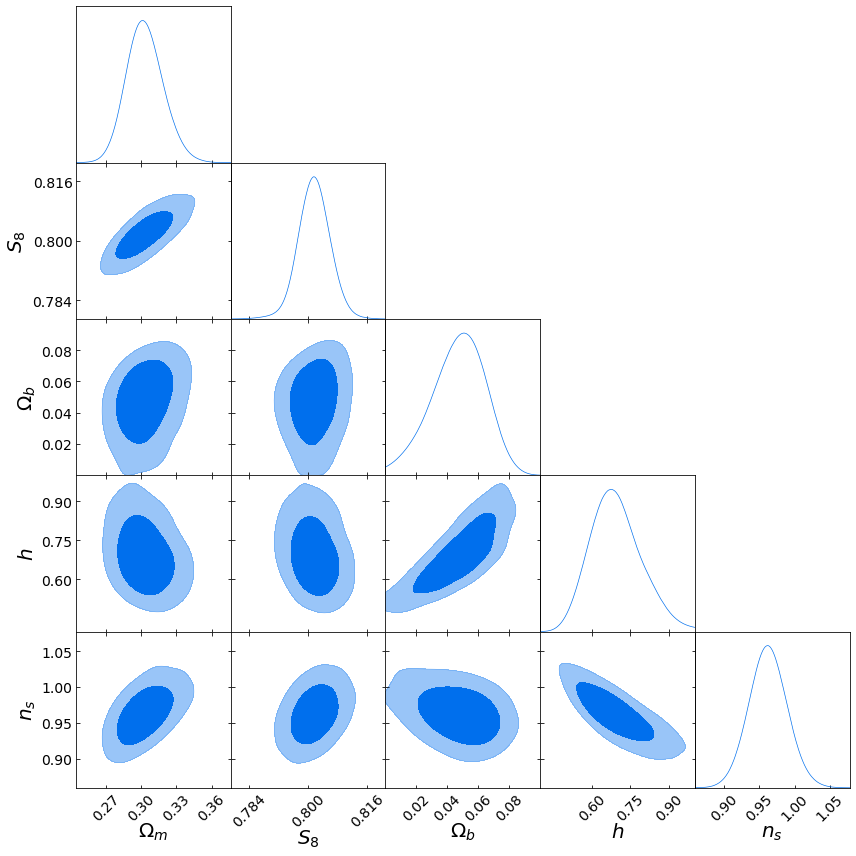

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 10s 2ms/step - loss: 3.9146 - val_loss: 4.0038
Epoch 2/100
5400/5400 [==============================] - 10s 2ms/step - loss: 3.9151 - val_loss: 3.9922
Epoch 3/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.9080 - val_loss: 3.9619
Epoch 4/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.9011 - val_loss: 3.9511
Epoch 5/100
5400/5400 [==============================] - 10s 2ms/step - loss: 3.9067 - val_loss: 3.9592
Epoch 6/100
5400/5400 [==============================] - 10s 2ms/step - loss: 3.9077 - val_loss: 3.9786
Epoch 7/100
5400/5400 [==============================] - 10s 2ms/step - loss: 3.9003 - val_loss: 3.9697
Epoch 8/100
5400/5400 [==============================] - 10s 2ms/step - loss: 3.9108 - val_loss: 3.9701
Epoch 9/100
5400/5400 [======================

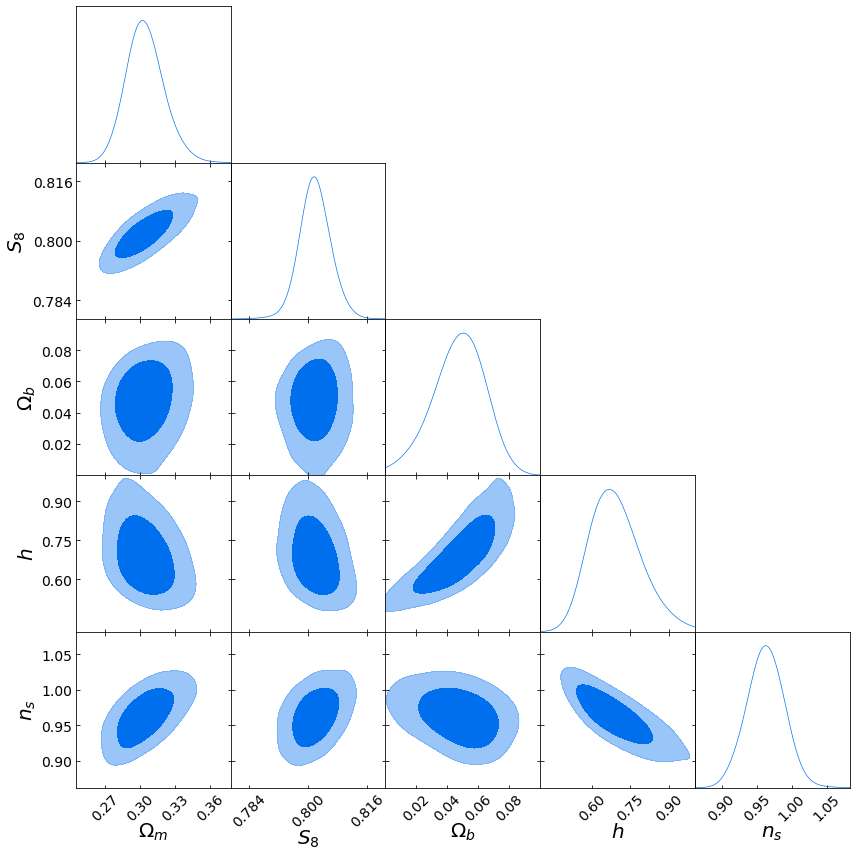

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5850 samples, validate on 650 samples
Epoch 1/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.9268 - val_loss: 3.8656
Epoch 2/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.9285 - val_loss: 3.8560
Epoch 3/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.9156 - val_loss: 3.8540
Epoch 4/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.9270 - val_loss: 3.8994
Epoch 5/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.9260 - val_loss: 3.8642
Epoch 6/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.9271 - val_loss: 3.8923
Epoch 7/100
5850/5850 [==============================] - 11s 2ms/step - loss: 3.9342 - val_loss: 3.9227
Epoch 8/100
5850/5850 [==============================] - 11s 2ms/step - loss: 3.9369 - val_loss: 3.8619
Epoch 9/100
5850/5850 [====================

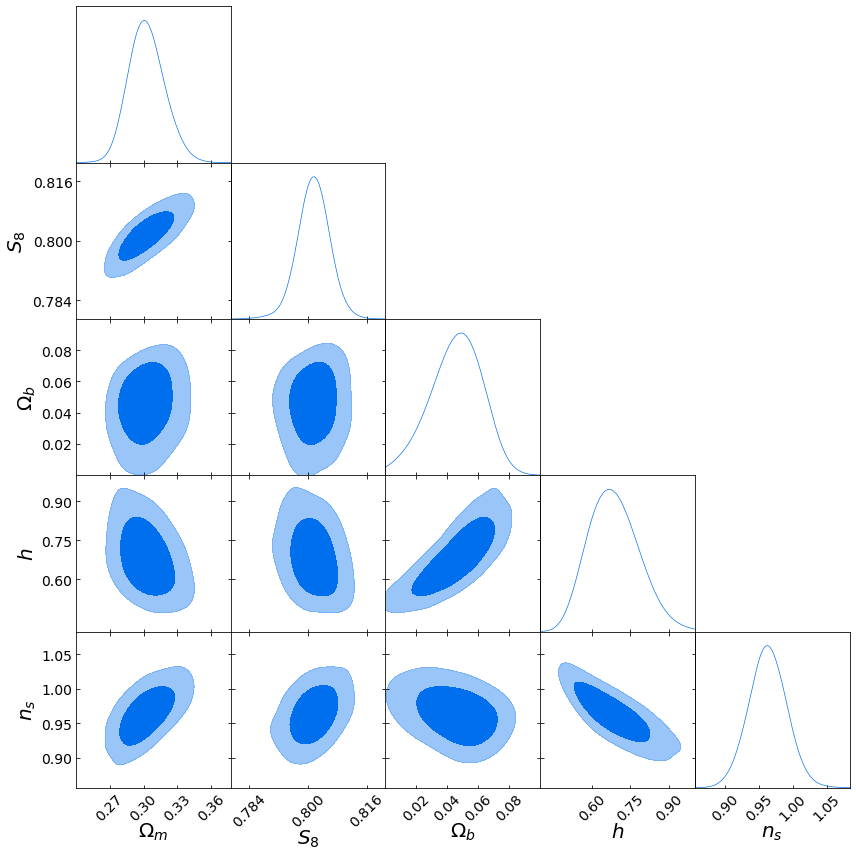

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 11s 2ms/step - loss: 3.9121 - val_loss: 3.7905
Epoch 2/100
6300/6300 [==============================] - 12s 2ms/step - loss: 3.9116 - val_loss: 3.7951
Epoch 3/100
6300/6300 [==============================] - 17s 3ms/step - loss: 3.9139 - val_loss: 3.8069
Epoch 4/100
6300/6300 [==============================] - 25s 4ms/step - loss: 3.9218 - val_loss: 3.8136
Epoch 5/100
6300/6300 [==============================] - 23s 4ms/step - loss: 3.9414 - val_loss: 3.9234
Epoch 6/100
6300/6300 [==============================] - 19s 3ms/step - loss: 3.9831 - val_loss: 3.7885
Epoch 7/100
6300/6300 [==============================] - 16s 3ms/step - loss: 3.9369 - val_loss: 3.8399
Epoch 8/100
6300/6300 [==============================] - 15s 2ms/step - loss: 3.9371 - val_loss: 3.8226
Epoch 9/100
6300/6300 [====================

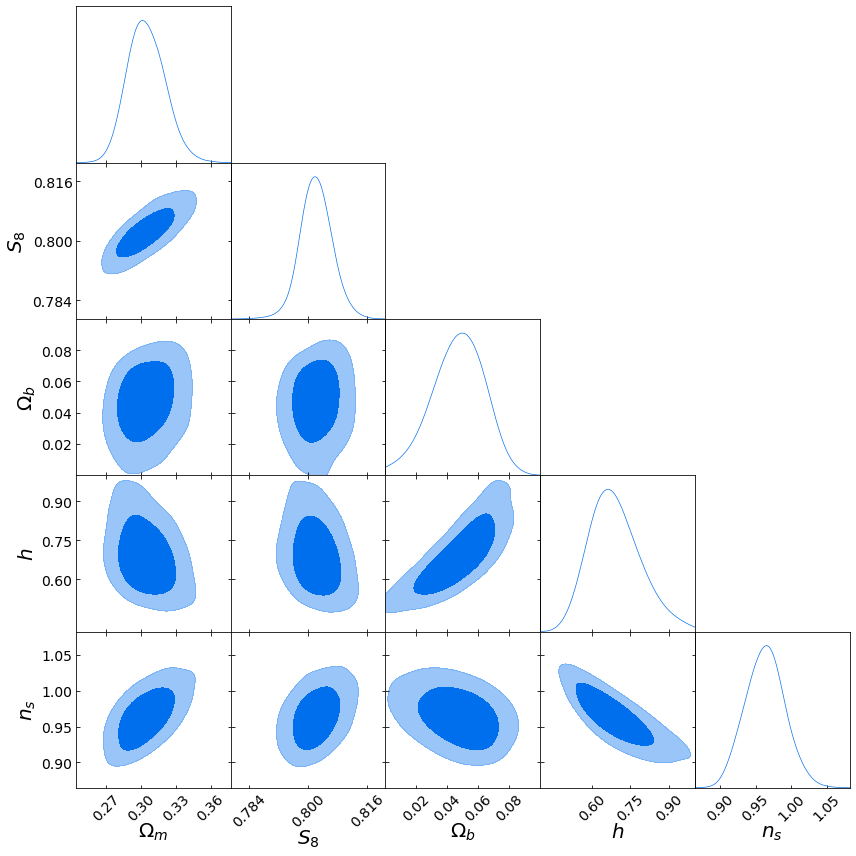

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 12s 2ms/step - loss: 3.9410 - val_loss: 3.7864
Epoch 2/100
6750/6750 [==============================] - 12s 2ms/step - loss: 3.9222 - val_loss: 3.7947
Epoch 3/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.9142 - val_loss: 3.7866
Epoch 4/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.9070 - val_loss: 3.8205
Epoch 5/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.9186 - val_loss: 3.7757
Epoch 6/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.9106 - val_loss: 3.8025
Epoch 7/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.9048 - val_loss: 3.7800
Epoch 8/100
6750/6750 [==============================] - 12s 2ms/step - loss: 3.9018 - val_loss: 3.7872
Epoch 9/100
6750/6750 [====================

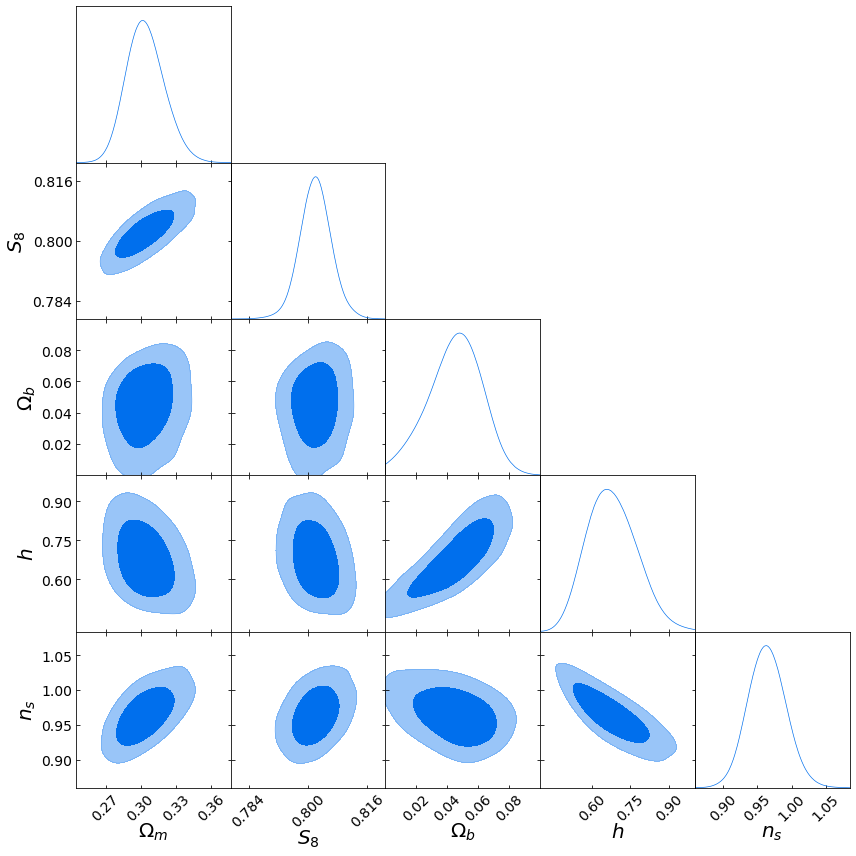

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 13s 2ms/step - loss: 3.8977 - val_loss: 3.8609
Epoch 2/100
7200/7200 [==============================] - 12s 2ms/step - loss: 3.8972 - val_loss: 3.8521
Epoch 3/100
7200/7200 [==============================] - 11s 2ms/step - loss: 3.9069 - val_loss: 3.8546
Epoch 4/100
7200/7200 [==============================] - 11s 2ms/step - loss: 3.8947 - val_loss: 3.8488
Epoch 5/100
7200/7200 [==============================] - 11s 2ms/step - loss: 3.8909 - val_loss: 3.8541
Epoch 6/100
7200/7200 [==============================] - 12s 2ms/step - loss: 3.8942 - val_loss: 3.8474
Epoch 7/100
7200/7200 [==============================] - 11s 2ms/step - loss: 3.9029 - val_loss: 3.8404
Epoch 8/100
7200/7200 [==============================] - 11s 2ms/step - loss: 3.8968 - val_loss: 3.8789
Epoch 9/100
7200/7200 [====================

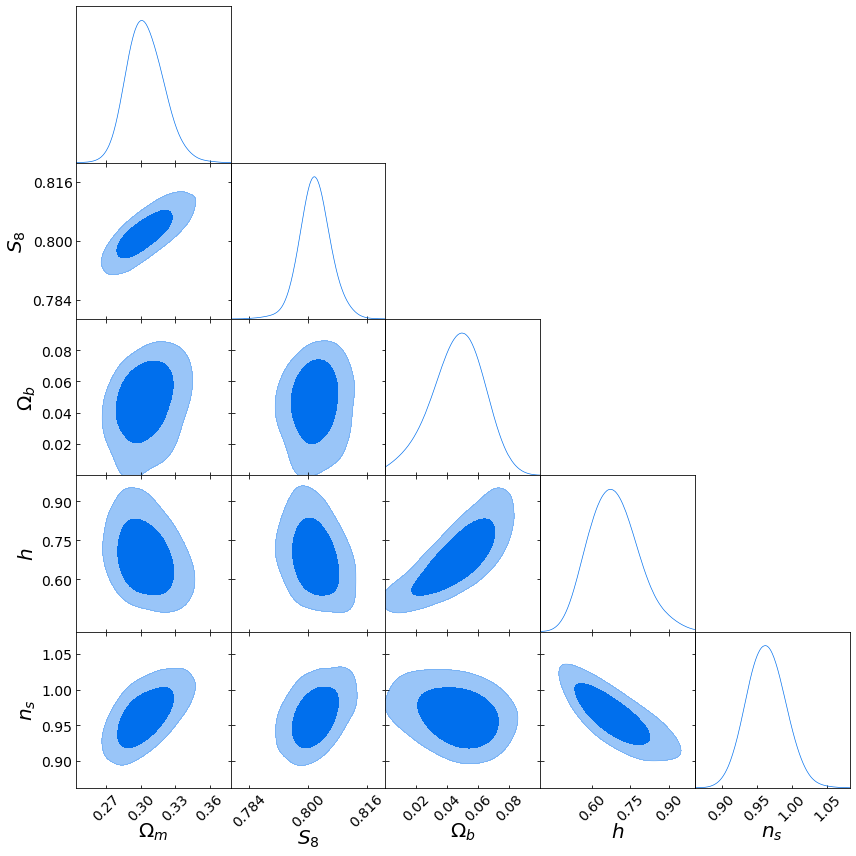

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7650 samples, validate on 850 samples
Epoch 1/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.8939 - val_loss: 3.9557
Epoch 2/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.9096 - val_loss: 3.9558
Epoch 3/100
7650/7650 [==============================] - 13s 2ms/step - loss: 3.8903 - val_loss: 3.9732
Epoch 4/100
7650/7650 [==============================] - 16s 2ms/step - loss: 3.9066 - val_loss: 3.9755
Epoch 5/100
7650/7650 [==============================] - 15s 2ms/step - loss: 3.9191 - val_loss: 3.9471
Epoch 6/100
7650/7650 [==============================] - 13s 2ms/step - loss: 3.8867 - val_loss: 3.9362
Epoch 7/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.8834 - val_loss: 3.9390
Epoch 8/100
7650/7650 [==============================] - 13s 2ms/step - loss: 3.8973 - val_loss: 3.9704
Epoch 9/100
7650/7650 [====================

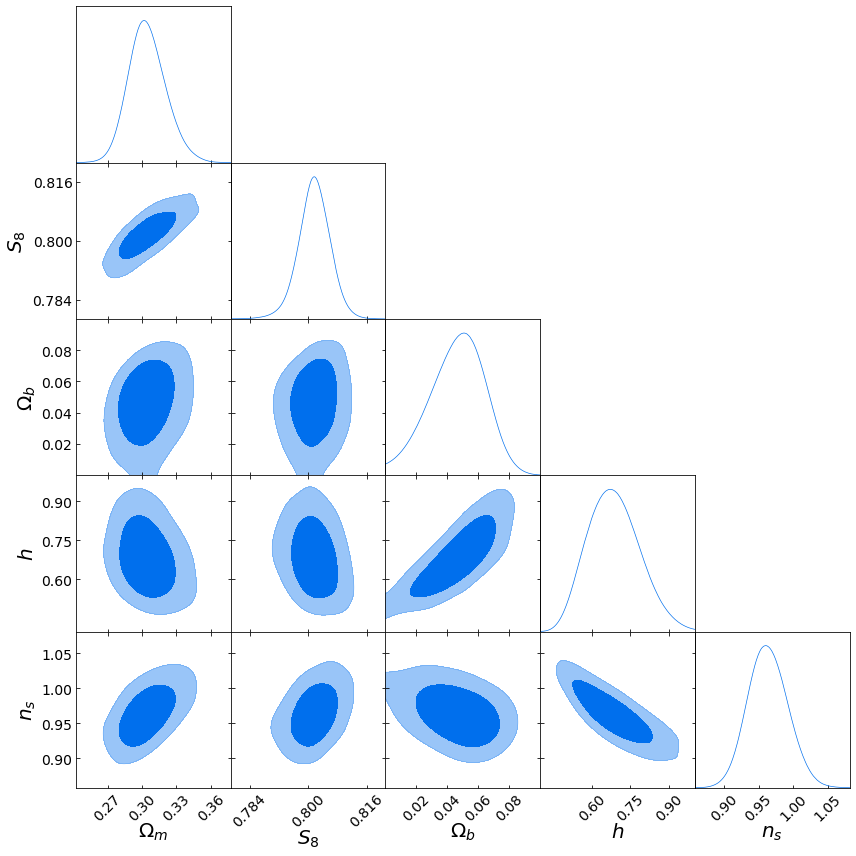

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 8100 samples, validate on 900 samples
Epoch 1/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.8923 - val_loss: 3.9338
Epoch 2/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.8976 - val_loss: 3.9775
Epoch 3/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.8989 - val_loss: 4.0426
Epoch 4/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.9054 - val_loss: 4.0287
Epoch 5/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.9185 - val_loss: 4.0965
Epoch 6/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.9406 - val_loss: 4.1513
Epoch 7/100
8100/8100 [==============================] - 13s 2ms/step - loss: 3.9429 - val_loss: 4.0902
Epoch 8/100
8100/8100 [==============================] - 12s 2ms/step - loss: 3.9206 - val_loss: 3.9772
Epoch 9/100
8100/8100 [====================

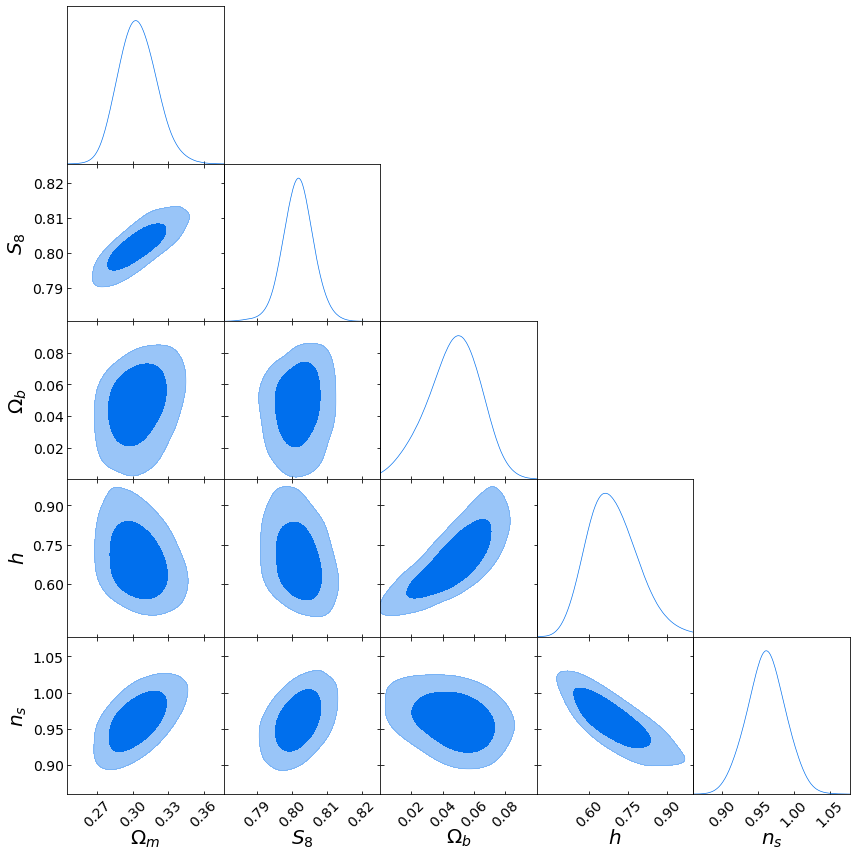

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator return exception with parameter values: [0.32999435 0.80288257 0.04263419 0.58198711 1.01167737]
Done.
Train on 8550 samples, validate on 950 samples
Epoch 1/100
8550/8550 [==============================] - 16s 2ms/step - loss: 3.8834 - val_loss: 3.9925
Epoch 2/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.8873 - val_loss: 4.0106
Epoch 3/100
8550/8550 [==============================] - 16s 2ms/step - loss: 3.8894 - val_loss: 3.9968
Epoch 4/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.8849 - val_loss: 4.0502
Epoch 5/100
8550/8550 [==============================] - 16s 2ms/step - loss: 3.9023 - val_loss: 4.0259
Epoch 6/100
8550/8550 [==============================] - 17s 2ms/step - loss: 3.8945 - val_loss: 4.0166
Epoch 7/100
8550/8550 [==============================] - 16s 2ms/step - loss: 3.8939 - val_loss: 4.0112
Epoch 8/100
8550/8550 [=================

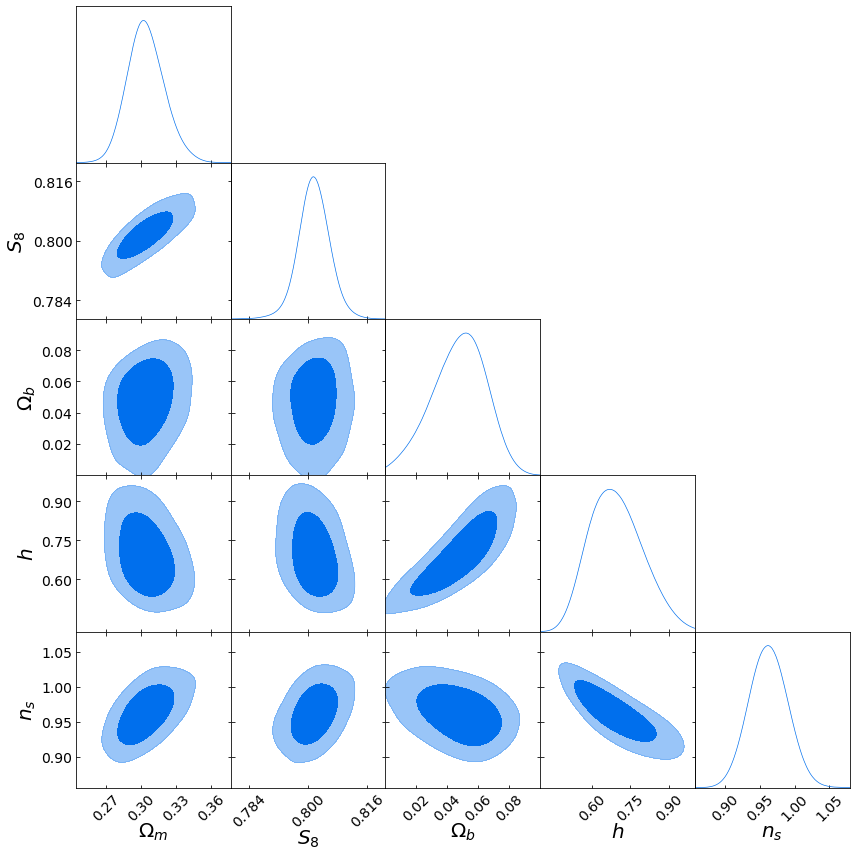

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 18s 2ms/step - loss: 3.8862 - val_loss: 3.9676
Epoch 2/100
9000/9000 [==============================] - 19s 2ms/step - loss: 3.8973 - val_loss: 3.9653
Epoch 3/100
9000/9000 [==============================] - 19s 2ms/step - loss: 3.9030 - val_loss: 3.9494
Epoch 4/100
9000/9000 [==============================] - 21s 2ms/step - loss: 3.8966 - val_loss: 3.9637
Epoch 5/100
9000/9000 [==============================] - 30s 3ms/step - loss: 3.8928 - val_loss: 3.9467
Epoch 6/100
9000/9000 [==============================] - 40s 4ms/step - loss: 3.8877 - val_loss: 3.9572
Epoch 7/100
9000/9000 [==============================] - 28s 3ms/step - loss: 3.8828 - val_loss: 3.9694
Epoch 8/100
9000/9000 [==============================] - 24s 3ms/step - loss: 3.8962 - val_loss: 3.9671
Epoch 9/100
9000/9000 [===================

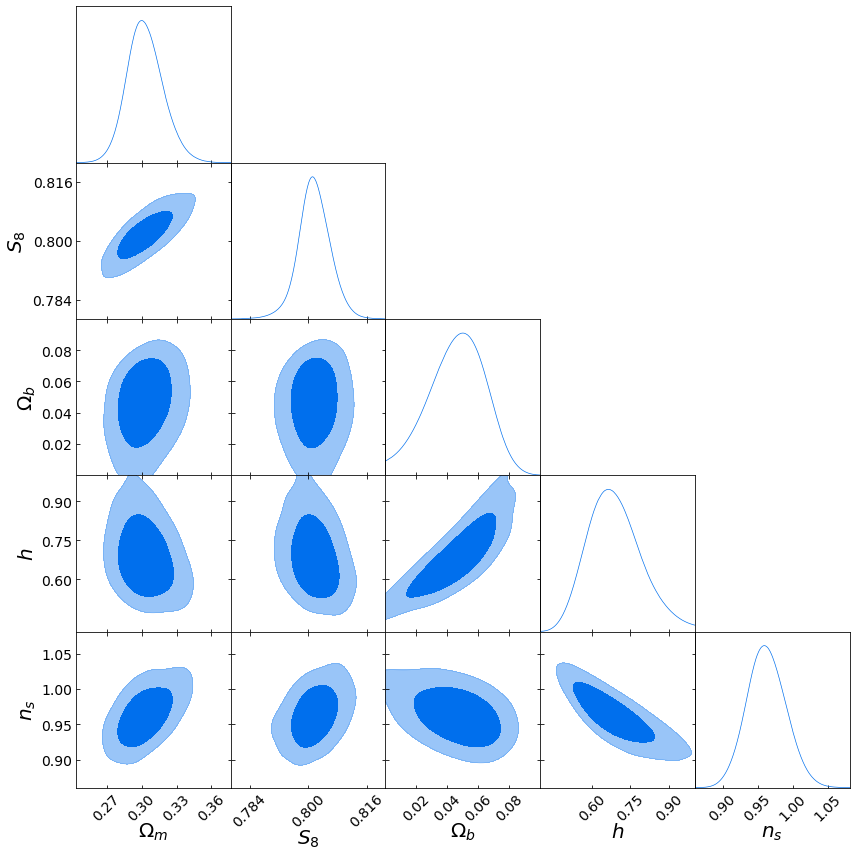

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9450 samples, validate on 1050 samples
Epoch 1/100
9450/9450 [==============================] - 15s 2ms/step - loss: 3.9040 - val_loss: 3.9423
Epoch 2/100
9450/9450 [==============================] - 15s 2ms/step - loss: 3.9212 - val_loss: 3.9371
Epoch 3/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.9107 - val_loss: 3.9037
Epoch 4/100
9450/9450 [==============================] - 18s 2ms/step - loss: 3.9004 - val_loss: 3.9259
Epoch 5/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.8979 - val_loss: 3.9122
Epoch 6/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.8993 - val_loss: 3.9144
Epoch 7/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.8956 - val_loss: 3.9025
Epoch 8/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.8895 - val_loss: 3.9093
Epoch 9/100
9450/9450 [===================

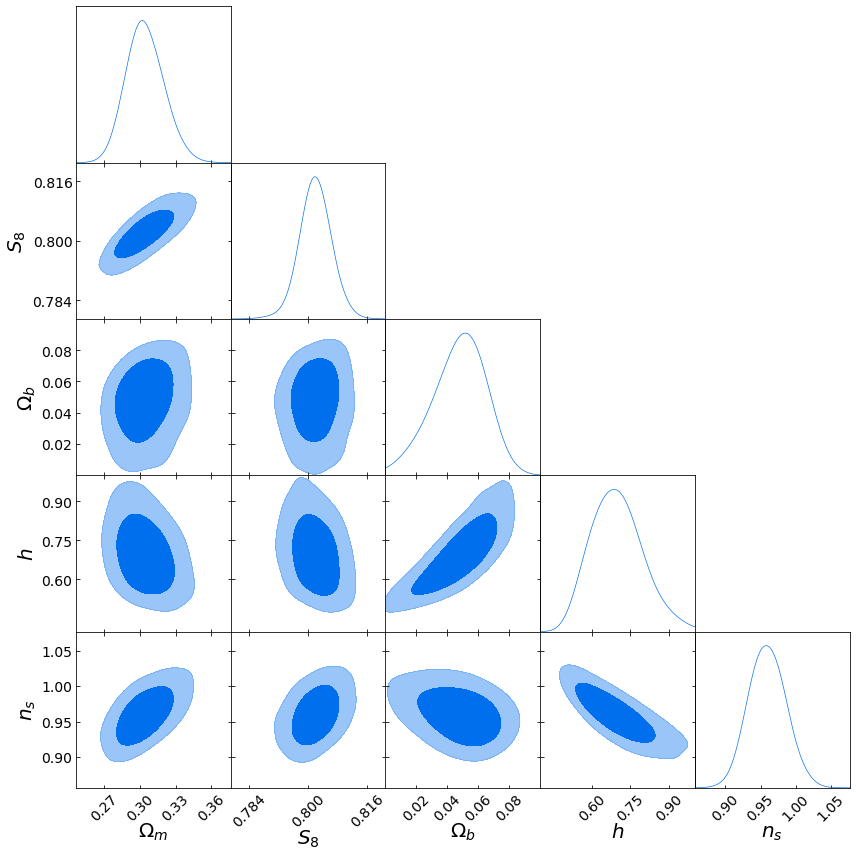

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9900 samples, validate on 1100 samples
Epoch 1/100
9900/9900 [==============================] - 20s 2ms/step - loss: 3.8970 - val_loss: 3.9097
Epoch 2/100
9900/9900 [==============================] - 18s 2ms/step - loss: 3.8924 - val_loss: 3.9305
Epoch 3/100
9900/9900 [==============================] - 22s 2ms/step - loss: 3.9124 - val_loss: 3.9823
Epoch 4/100
9900/9900 [==============================] - 16s 2ms/step - loss: 3.9246 - val_loss: 3.9634
Epoch 5/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.9098 - val_loss: 3.9128
Epoch 6/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.9007 - val_loss: 3.9341
Epoch 7/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.9044 - val_loss: 3.9130
Epoch 8/100
9900/9900 [==============================] - 16s 2ms/step - loss: 3.8944 - val_loss: 3.9139
Epoch 9/100
9900/9900 [===================

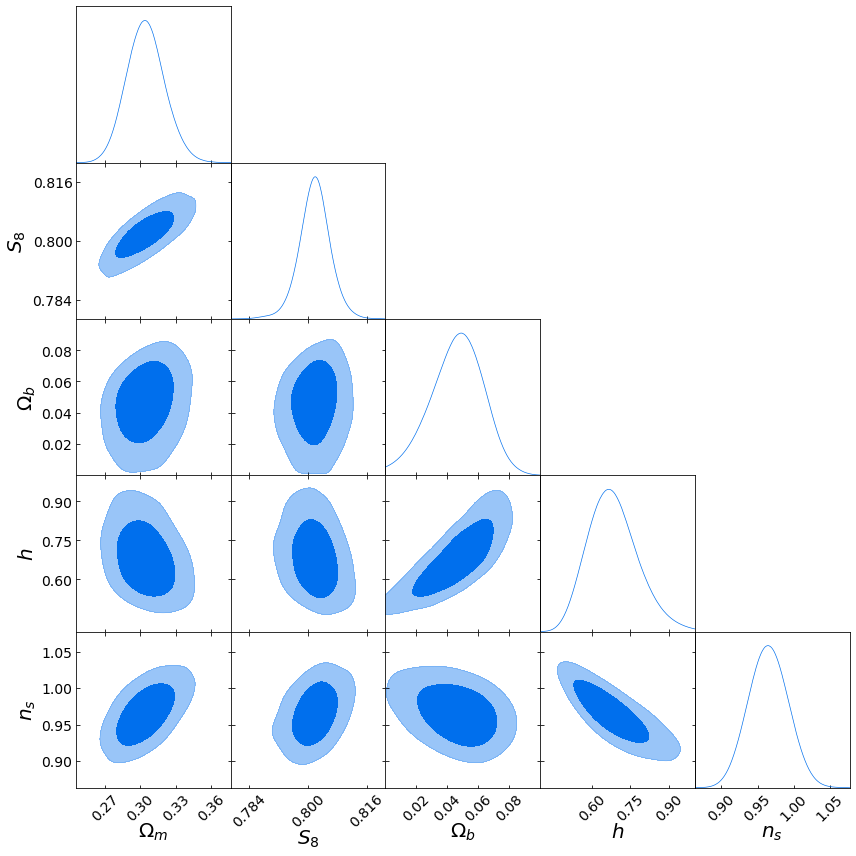

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 10350 samples, validate on 1150 samples
Epoch 1/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.8781 - val_loss: 3.8820
Epoch 2/100
10350/10350 [==============================] - 17s 2ms/step - loss: 3.8844 - val_loss: 3.8865
Epoch 3/100
10350/10350 [==============================] - 17s 2ms/step - loss: 3.8945 - val_loss: 3.8965
Epoch 4/100
10350/10350 [==============================] - 22s 2ms/step - loss: 3.8985 - val_loss: 3.8855
Epoch 5/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.8938 - val_loss: 3.8865
Epoch 6/100
10350/10350 [==============================] - 19s 2ms/step - loss: 3.8893 - val_loss: 3.8862
Epoch 7/100
10350/10350 [==============================] - 17s 2ms/step - loss: 3.8926 - val_loss: 3.8740
Epoch 8/100
10350/10350 [==============================] - 17s 2ms/step - loss: 3.8877 - val_loss: 3.8845
Epoch 9/100
10350/10350 [

In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

In [11]:
n_sims = mdn.n_sim_trace[1:]
loss_trace = mdn.loss_trace[1:]

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


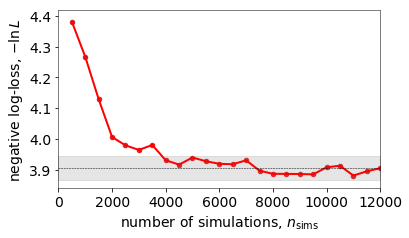

In [14]:
plt.close()
columnwidth = 15 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})

# Trace plot of the loss as a function of the number of simulations
plt.scatter(n_sims, loss_trace, s = 20)
plt.plot(n_sims, loss_trace, color = 'red', lw = 2)
plt.fill_between(mdn.n_sim_trace, loss_trace[-1]*0.99*np.ones(len(mdn.n_sim_trace)), loss_trace[-1]*1.01*np.ones(len(mdn.n_sim_trace)), color = 'grey', alpha = 0.2 )
plt.xlim(0, mdn.n_sim_trace[-1])
plt.axhline(loss_trace[-1], color = 'black', ls = '--')
plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log-loss, $-\mathrm{ln}\,L$')
plt.tight_layout()
#plt.show()
#plt.savefig('../paper_II/plots/convergence_marginal.pdf')

In [46]:
# Generate draws from asymptotic posterior
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
#samples_asymptotic[:,1] += 0.001

In [47]:
samples = [mdn.posterior_samples, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = mdn.names, labels = mdn.labels, ranges = mdn.ranges) for s in samples]

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


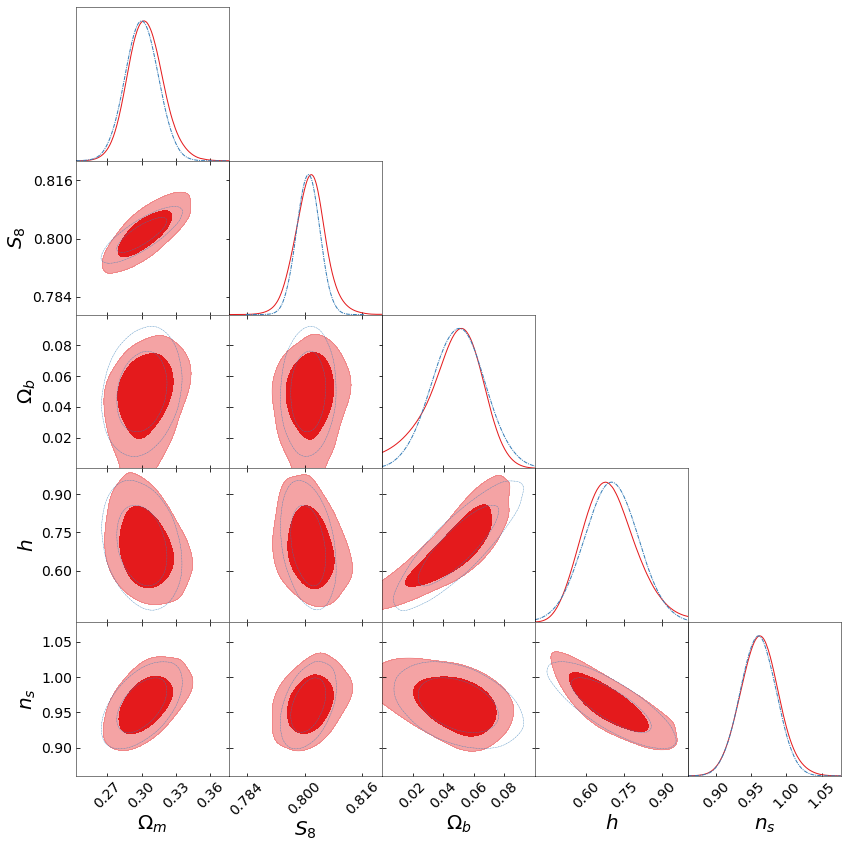

In [64]:
# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-.'], contour_colors=['#E41A1C','#377EB8'])

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
#plt.savefig('../paper_II/plots/contours.pdf')